In [114]:
# Tabular Clasification with Pytorch

%pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Note: you may need to restart the kernel to use updated packages.
Skipping, found downloaded files in ".\rice-type-classification" (use force=True to force download)


In [115]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [116]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [117]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import os

In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())  # Should print: True
print(torch.cuda.get_device_name())  # Should print your GPU name

cuda
True
NVIDIA GeForce RTX 3060


In [119]:
base_path = Path(os.getcwd()).resolve()

data_df = pd.read_csv(base_path/"rice-type-classification"/"riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [120]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis = 1, inplace = True)
print(data_df.shape)

(18185, 11)


In [121]:
print(data_df["Class"].unique())

[1 0]


In [122]:
print(data_df["Class"].value_counts())

1    9985
0    8200
Name: Class, dtype: int64


In [123]:
original_df = data_df.copy()

for column in data_df.columns:
    data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [124]:
X = np.array(data_df.iloc[:,:-1])
y = np.array(data_df.iloc[:,-1])

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [126]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [127]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [128]:
training_data = TabularDataset(X_train, y_train)
validation_data = TabularDataset(X_val, y_val)
testing_data = TabularDataset(X_test, y_test)

In [129]:
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size = 32, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size = 32, shuffle=False)

In [130]:
for x, y in train_dataloader:
    print(x)
    print("======")
    print(y)
    break

tensor([[0.6062, 0.8029, 0.6615, 0.9605, 0.5810, 0.7786, 0.5771, 0.6989, 0.6805,
         0.6887],
        [0.6112, 0.8563, 0.6231, 0.9772, 0.5862, 0.7818, 0.7124, 0.6968, 0.6903,
         0.7797],
        [0.6239, 0.9001, 0.6037, 0.9860, 0.5955, 0.7899, 0.5193, 0.7098, 0.6791,
         0.8459],
        [0.4565, 0.7350, 0.5414, 0.9757, 0.4335, 0.6757, 0.7376, 0.5861, 0.7288,
         0.7703],
        [0.3597, 0.5415, 0.5856, 0.9033, 0.3416, 0.5998, 0.8991, 0.4744, 0.8766,
         0.5247],
        [0.5627, 0.5776, 0.8564, 0.7697, 0.5317, 0.7501, 0.8411, 0.5609, 0.9807,
         0.3826],
        [0.8694, 0.8637, 0.8791, 0.9192, 0.8329, 0.9324, 0.6576, 0.7593, 0.8271,
         0.5574],
        [0.6790, 0.9203, 0.6497, 0.9807, 0.6461, 0.8240, 0.5621, 0.7258, 0.7070,
         0.8037],
        [0.7167, 0.7728, 0.8040, 0.9137, 0.6866, 0.8466, 0.6859, 0.6966, 0.8100,
         0.5453],
        [0.5800, 0.7909, 0.6419, 0.9627, 0.5519, 0.7616, 0.6357, 0.6518, 0.7488,
         0.6991],
        [0

In [131]:
HIDDEN_NEURONS = 15

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
    
model = MyModel().to(device)

In [132]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 15]             165
            Linear-2                    [-1, 1]              16
           Sigmoid-3                    [-1, 1]               0
Total params: 181
Trainable params: 181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [133]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-4)

In [134]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for data in train_dataloader:
        inputs, labels = data
        
        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()
            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc
    total_loss_train_plot.append(round(total_loss_train/1000, 4))  
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))  

    total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))  
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))  

    print(f'''Epoch no. {epoch+1} Train Loss:{round(total_loss_train/1000, 4)} Train Accuracy {round(total_acc_train/training_data.__len__() * 100, 4)}
            Validation Loss: {round(total_loss_val/1000, 4)} Validation Accuracy: {round(total_acc_val/validation_data.__len__() * 100, 4)}''')
    print("="*25)
    


Epoch no. 1 Train Loss:0.2711 Train Accuracy 54.474
            Validation Loss: 0.0577 Validation Accuracy: 57.0015
Epoch no. 2 Train Loss:0.2642 Train Accuracy 70.6261
            Validation Loss: 0.0561 Validation Accuracy: 81.3783
Epoch no. 3 Train Loss:0.256 Train Accuracy 86.7625
            Validation Loss: 0.0542 Validation Accuracy: 91.7522
Epoch no. 4 Train Loss:0.246 Train Accuracy 93.0159
            Validation Loss: 0.0518 Validation Accuracy: 94.7947
Epoch no. 5 Train Loss:0.2341 Train Accuracy 95.2706
            Validation Loss: 0.0489 Validation Accuracy: 96.1877
Epoch no. 6 Train Loss:0.2204 Train Accuracy 96.3626
            Validation Loss: 0.0458 Validation Accuracy: 96.8475
Epoch no. 7 Train Loss:0.2054 Train Accuracy 97.1404
            Validation Loss: 0.0424 Validation Accuracy: 97.2141
Epoch no. 8 Train Loss:0.1897 Train Accuracy 97.2189
            Validation Loss: 0.0389 Validation Accuracy: 97.9472
Epoch no. 9 Train Loss:0.1737 Train Accuracy 97.596
       

In [135]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    
    for data in testing_dataloader:
        input, labels = data
        
        prediction = model(input).squeeze(1)

        batch_loss_test = criterion(prediction, labels).item()
        total_loss_test += batch_loss_test

        acc = ((prediction).round() == labels).sum().item()

        total_acc_test += acc

print("Accuracy: ", round(total_acc_test/testing_data.__len__() *100, 4))

Accuracy:  98.2405


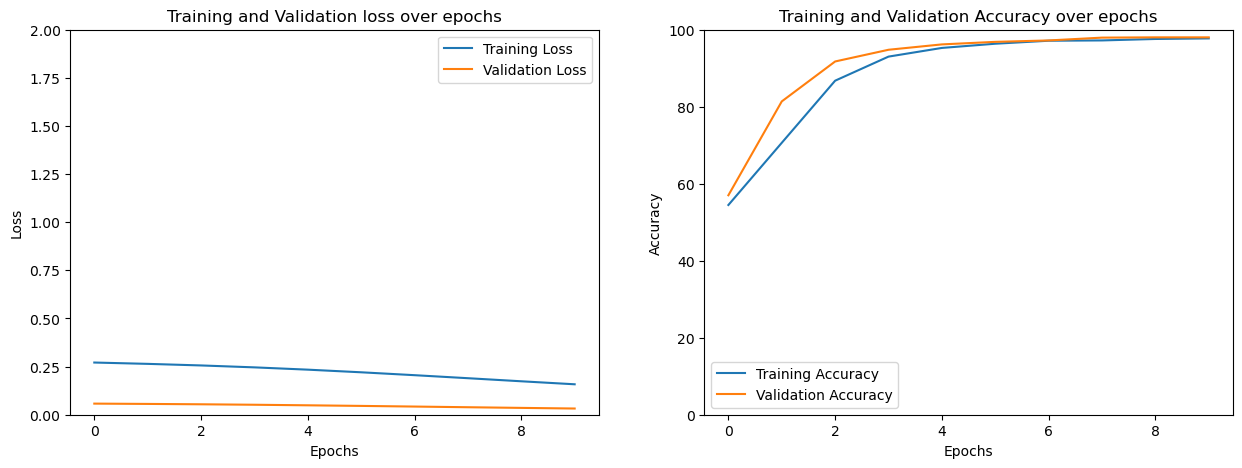

In [136]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Training Accuracy')
axs[1].plot(total_acc_validation_plot, label = 'Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [137]:
original_df.columns

Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation', 'Class'],
      dtype='object')

In [138]:
# Normalization of new values to run in model

Area = 2353/original_df['Area'].abs().max()
MajorAxisLength = 42/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = 81/original_df['MinorAxisLength'].abs().max()
Eccentricity = 12/original_df['Eccentricity'].abs().max()
ConvexArea = 32/original_df['ConvexArea'].abs().max()
EquivDiameter = 33/original_df['EquivDiameter'].abs().max()
Extent = 98/original_df['Extent'].abs().max()
Perimeter = 927/original_df['Perimeter'].abs().max()
Roundness = 677/original_df['Roundness'].abs().max()
AspectRation = 24/original_df['AspectRation'].abs().max()

my_prediction = model(torch.tensor([Area, MajorAxisLength, MinorAxisLength, Eccentricity,ConvexArea, EquivDiameter, Extent, Perimeter, Roundness,AspectRation], dtype = torch.float32).to(device))

In [143]:
# Based on the dataset 
# Jasmine - 1, Gonen - 0.

if my_prediction <= 0.5:
    print("The new sample's class is Gonen")
else:
    print("The new sample's class is Jasmine")

The new sample's class is Gonen
